In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Import all Modules


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

##Read the Dataset


In [3]:
df = pd.read_csv("/content/drive/MyDrive/KDSH Data/btc_15m.csv") # Change the path for the csv file accordingly

In [4]:
df.head()


,datetime,open,high,low,close,volume
0,2018-01-01 05:30:00,13715.65,13715.65,13400.01,13556.15,123.616013
1,2018-01-01 05:45:00,13533.75,13550.87,13402.00,13521.12,98.136430
2,2018-01-01 06:00:00,13500.00,13545.37,13450.00,13470.41,79.904037
3,2018-01-01 06:15:00,13494.65,13690.87,13450.00,13529.01,141.699719
4,2018-01-01 06:30:00,13528.99,13571.74,13402.28,13445.63,72.537533


##Split into Training & Testing Set


In [5]:
df = df.dropna()  # Drop rows with missing values
df = df.reset_index(drop=True)  # Reset index after dropping rows
dataframe_training, dataframe_testing, y_train, y_test = train_test_split(
    df, df, test_size=0.2, random_state=42
)

##Pre-processing of Training Set


In [6]:
training_set = dataframe_training.iloc[:,1:2].values

In [7]:
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set)

##Pre-processing of Testing Set


In [8]:
testing_set = dataframe_testing.iloc[:,1:2].values
dataframe_testing.head()

,datetime,open,high,low,close,volume
35964,2019-01-13 14:00:00,3586.39,3587.67,3577.63,3578.11,92.581132
57054,2019-08-22 07:30:00,9819.03,9865.82,9762.00,9819.46,927.547381
36792,2019-01-22 05:00:00,3532.77,3534.34,3525.47,3527.09,207.134286
30520,2018-11-17 21:00:00,5604.69,5612.00,5601.04,5603.57,255.843308
85570,2020-06-15 00:00:00,9381.21,9386.56,9376.17,9380.68,198.392004


In [9]:

dataframe_training.head()


,datetime,open,high,low,close,volume
49821,2019-06-07 14:15:00,7958.36,7967.71,7942.91,7954.27,306.504543
64722,2019-11-10 04:30:00,8796.05,8808.42,8790.12,8806.51,150.454382
74911,2020-02-24 18:45:00,9783.04,9811.10,9780.42,9792.54,483.119116
2787,2018-01-30 08:00:00,11040.00,11094.83,11022.01,11032.00,109.619743
24374,2018-09-14 10:00:00,6550.37,6570.00,6539.15,6541.98,228.680587


##Number of timesteps


In [10]:
timesteps = 60

In [11]:
X_train = []
Y_train = []

for i in range(timesteps, len(training_set_scaled)):
    #APPEND INTO X_TRAIN: ROWS, COLUMN
    X_train.append(training_set_scaled[i-timesteps:i, 0]) #MEMORY
    Y_train.append(training_set_scaled[i, 0]) #PREDICTIONS

##Convert to Numpy Array


In [12]:
X_train, Y_train = np.array(X_train), np.array(Y_train)

##Reshape to add new dimension


In [13]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

##Construct the RNN


In [14]:
regressor = Sequential()

In [15]:
regressor.add(LSTM(
    units = 50,
    return_sequences=True,
    input_shape = (X_train.shape[1], 1)
    ))

regressor.add(Dropout(
    rate = 0.2
))

regressor.add(LSTM(
    units = 50,
    return_sequences=True,
    ))

regressor.add(Dropout(
    rate = 0.2
  ))

regressor.add(LSTM(
    units = 50,
    return_sequences=True,
    ))

regressor.add(Dropout(
    rate = 0.2
  ))


regressor.add(LSTM(
    units = 50,
    return_sequences=False,
    ))

regressor.add(Dropout(
    rate = 0.2
  ))


#FINAL - OUTPUT LAYER
regressor.add(Dense(
    units = 1
    ))

##Compile RNN


In [16]:
regressor.compile(
    optimizer = "adam", #ALWAYS A SAFE CHOICE; RNN, ANN
    loss  = "mean_squared_error" #MSE FOR REGRESSION
    )

##Fit RNN


In [30]:
regressor.fit(
    X_train,
    Y_train,
    epochs = 5,
    batch_size =  32
    )
# The epochs can be changed modified according to our need, for this model we have taken epochs = 5

Epoch 1/3
3564/3564 [==============================] - 431s 121ms/step - loss: 0.0745
Epoch 2/3
3564/3564 [==============================] - 437s 123ms/step - loss: 0.0745
Epoch 3/3
3564/3564 [==============================] - 434s 122ms/step - loss: 0.0745


##Making Predictions


In [31]:
df_prediction = pd.concat(
    (dataframe_training['open'], dataframe_testing['open']),
    axis=0  # ROWS; NOT COLUMNS
)


In [32]:
inputs = df_prediction[len(df_prediction)-len(dataframe_testing)-60:].values

In [33]:
inputs = np.reshape(inputs, (-1, 1))
inputs = sc.transform(inputs)

X_test = []
for i in range(60, 80):
     #APPEND INTO X_TRAIN: ROWS, COLUMN
     X_test.append(inputs[i-60:i, 0]) #MEMORY


## BACKTESTING

1/1 [==============================] - 0s 68ms/step


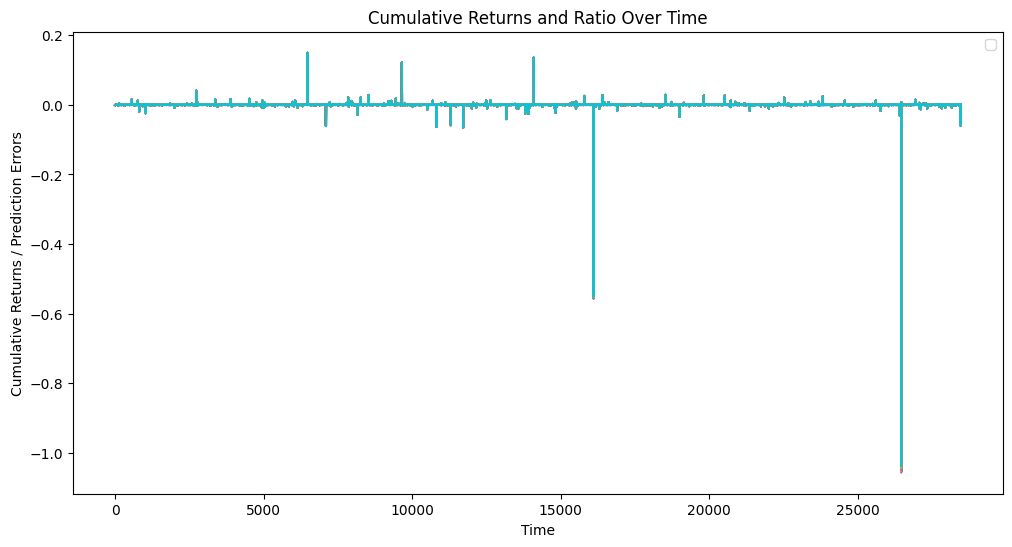

In [99]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_prices = regressor.predict(X_test)

# Inverse transform the predicted prices to get them in the original scale
predicted_prices = sc.inverse_transform(predicted_prices)

actual_prices = testing_set[timesteps:]
returns = (actual_prices[1:] - actual_prices[:-1]) / actual_prices[:-1]

# Calculate trading signals based on predicted price changes
predicted_returns = (predicted_prices[1:] - predicted_prices[:-1]) / predicted_prices[:-1]
buy_signals = predicted_returns > 0  # Buy when the model predicts a positive return

# Assuming a constant transaction cost and slippage for simplicity
transaction_cost = 0.0015
slippage = 0.002

# Ensure buy_signals has the same length as returns
buy_signals = buy_signals[:len(returns)]

buy_signals_expanded = np.expand_dims(buy_signals, axis=-1)

adjusted_returns = returns - (buy_signals_expanded * transaction_cost) - (buy_signals_expanded * slippage)

# Reshape predicted_prices to match the shape of actual_prices
predicted_prices = predicted_prices[:len(actual_prices)].flatten()

# Calculate errors
errors = actual_prices - predicted_prices

# Calculate cumulative returns
cumulative_returns = np.cumprod(1 + adjusted_returns) - 1

# Trim the longer array to match the length of the shorter array
min_length = min(len(cumulative_returns), len(errors))
cumulative_returns_trimmed = cumulative_returns[:min_length]
errors_trimmed = errors[:min_length]

# Reshape cumulative_returns_trimmed to be a 2D array
cumulative_returns_trimmed = cumulative_returns_trimmed.reshape(-1, 1)

# Calculate the ratio of cumulative returns to prediction errors
y = cumulative_returns_trimmed / errors_trimmed

# Flatten errors_trimmed to make it 1D
errors_flat = errors_trimmed.flatten()

# Plot cumulative returns and scatter plot of errors
plt.figure(figsize=(12, 6))
plt.plot(y)
plt.xlabel('Time')
plt.ylabel('Cumulative Returns / Prediction Errors')
plt.title('Cumulative Returns and Ratio Over Time')
plt.legend()
plt.show()

1/1 [==============================] - 0s 71ms/step


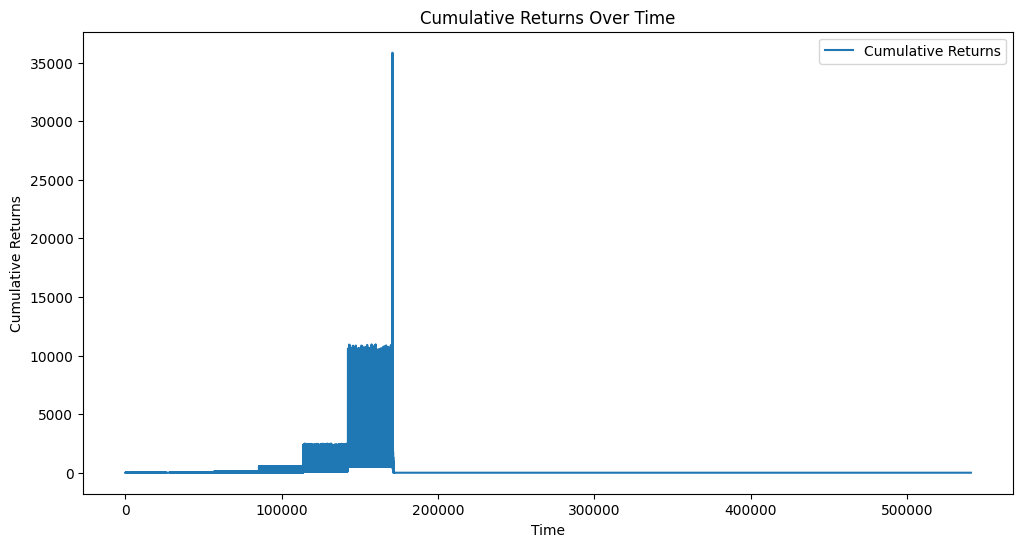

In [101]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_prices = regressor.predict(X_test)

predicted_prices = sc.inverse_transform(predicted_prices)

actual_prices = testing_set[timesteps:]

returns = (actual_prices[1:] - actual_prices[:-1]) / actual_prices[:-1]

predicted_returns = (predicted_prices[1:] - predicted_prices[:-1]) / predicted_prices[:-1]
buy_signals = predicted_returns > 0

transaction_cost = 0.0015
slippage = 0.002

buy_signals = buy_signals[:len(returns)]

buy_signals_expanded = np.expand_dims(buy_signals, axis=-1)

adjusted_returns = returns - (buy_signals_expanded * transaction_cost) - (buy_signals_expanded * slippage)

cumulative_returns = np.cumprod(1 + adjusted_returns) - 1

plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label='Cumulative Returns')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.show()


## RISK MANAGEMENT

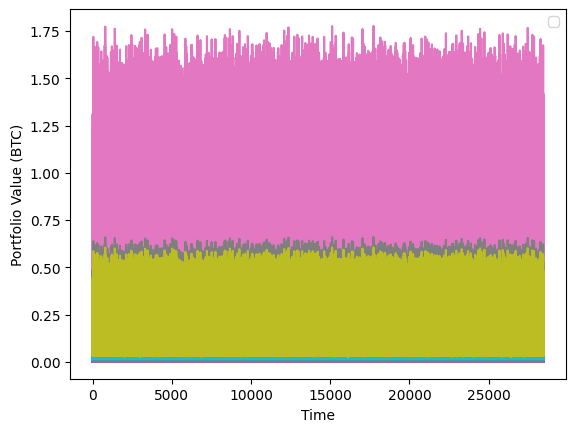

In [100]:
stop_loss_ratio = 0.02  # 2% stop-loss ratio

positions = np.zeros(len(adjusted_returns))
capital = 1.0  # Initial capital is set to 1 BTC for simplicity
position_size = 0.1  # Example: Allocate 10% of capital to each trade

# Loop through each time step
for i in range(len(adjusted_returns)):

    position_size_btc = capital * position_size

    # Check if the model predicts a positive return (buy signal)
    if buy_signals[i]:

        positions[i] = position_size_btc / actual_prices[i]

    # Check if stop-loss condition is met (sell signal)
    elif positions[i-1] * (1 - stop_loss_ratio) > actual_prices[i]:
        positions[i] = 0

portfolio_value = positions * actual_prices

plt.plot(portfolio_value)
plt.xlabel('Time')
plt.ylabel('Portfolio Value (BTC)')
plt.legend()
plt.show()


## VALUES

In [40]:
# Calculate metrics
gross_profit = np.sum(adjusted_returns[adjusted_returns > 0])
gross_loss = -np.sum(adjusted_returns[adjusted_returns < 0])
net_profit = gross_profit - gross_loss
total_closed_trades = np.sum(buy_signals)
win_rate = np.sum(adjusted_returns > 0) / total_closed_trades
max_drawdown = np.min(np.cumsum(adjusted_returns))
average_winning_trade = gross_profit / np.sum(adjusted_returns > 0)
average_losing_trade = gross_loss / np.sum(adjusted_returns < 0)
buy_and_hold_return = (actual_prices[-1] - actual_prices[0]) / actual_prices[0]
largest_losing_trade = np.min(adjusted_returns)
largest_winning_trade = np.max(adjusted_returns)
sharpe_ratio = np.sqrt(252) * np.mean(adjusted_returns) / np.std(adjusted_returns)
sortino_ratio = np.sqrt(252) * np.mean(adjusted_returns) / np.std(adjusted_returns[adjusted_returns < 0])
average_holding_duration = np.mean(np.diff(np.where(buy_signals)[0])) if np.sum(buy_signals) > 0 else 0
benchmark_return = (actual_prices[-1] - actual_prices[0]) / actual_prices[0]
risk_reward_ratio = np.mean(adjusted_returns) / np.std(adjusted_returns)
trade_durations = np.diff(np.where(buy_signals)[0])
max_duration_time = np.max(trade_durations) if len(trade_durations) > 0 else 0


print(f"Gross Profit: {gross_profit}")
print(f"Gross Loss: {gross_loss}")
print(f"Net Profit: {net_profit}")
print(f"Total Closed Trades: {total_closed_trades}")
print(f"Win Rate: {win_rate}")
print(f"Max Drawdown: {max_drawdown}")
print(f"Average Winning Trade (in USDT): {average_winning_trade}")
print(f"Average Losing Trade (in USDT): {average_losing_trade}")
print(f"Buy and Hold Return of BTC: {buy_and_hold_return}")
print(f"Largest Losing Trade (in USDT): {largest_losing_trade}")
print(f"Largest Winning Trade (in USDT): {largest_winning_trade}")
print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Sortino Ratio: {sortino_ratio}")
print(f"Average Holding Duration per Trade: {average_holding_duration} days")
print(f"Benchmark Return: {benchmark_return}")
print(f"Risk-Reward Ratio: {risk_reward_ratio}")
print(f"Max Duration Time of Single Trade: {max_duration_time} days")

Gross Profit: 665217.2869856787
Gross Loss: 135377.7613746223
Net Profit: 529839.5256110565
Total Closed Trades: 8
Win Rate: 33776.125
Max Drawdown: 3.0191753513035224
Average Winning Trade (in USDT): 2.4618620659773685
Average Losing Trade (in USDT): 0.5003798239682953
Buy and Hold Return of BTC: [3.39734455]
Largest Losing Trade (in USDT): -0.953402700933832
Largest Winning Trade (in USDT): 18.95807726753343
Sharpe Ratio: 5.954393888136529
Sortino Ratio: 51.99158663836698
Average Holding Duration per Trade: 1.7142857142857142 days
Benchmark Return: [3.39734455]
Risk-Reward Ratio: 0.3750915580031478
Max Duration Time of Single Trade: 6 days
